In [12]:
import os

from glob import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime


import furniture_bench
import gym

import torch

from tqdm import tqdm

In [2]:
max_env_steps = 500

env = gym.make(
  "FurnitureSimFull-v0",
  furniture="lamp",         # Specifies the type of furniture [lamp | square_table | desk | drawer | cabinet | round_table | stool | chair | one_leg].
  num_envs=1,               # Number of parallel environments.
  resize_img=True,          # If true, images are resized to 224 x 224.
  headless=True,            # If true, simulation runs without GUI.
  compute_device_id=0,      # GPU device ID for simulation.
  graphics_device_id=0,     # GPU device ID for rendering.
  init_assembled=False,     # If true, the environment is initialized with assembled furniture.
  np_step_out=False,        # If true, env.step() returns Numpy arrays.
  channel_first=False,      # If true, images are returned in channel first format.
  randomness="low",         # Level of randomness in the environment [low | med | high].
  high_random_idx=-1,       # Index of the high randomness level (range: [0-2]). Default -1 will randomly select the index within the range.
  save_camera_input=False,  # If true, the initial camera inputs are saved.
  record=False,              # If true, videos of the wrist and front cameras' RGB inputs are recorded.
  max_env_steps=max_env_steps,       # Maximum number of steps per episode.
  act_rot_repr='quat'       # Representation of rotation for action space. Options are 'quat' and 'axis'.
)

PyTorch version 2.0.1+cu117
Device count 1
/home/azureuser/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/azureuser/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/azureuser/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


KeyboardInterrupt: 

In [ ]:
observations = [env.reset()]

done = False

pbar = tqdm(total=max_env_steps, ncols=100)

while not done:
    ac = torch.tensor(env.action_space.sample()).float().to('cuda') # (1, 8) torch.Tensor
    ob, rew, done, _ = env.step(ac)
    observations.append(ob)
    pbar.update()

INFO: Found collision-free init pose
100%|█████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 15.49it/s]/home/azureuser/miniconda3/envs/rlgpu/lib/python3.8/site-packages/furniture_bench/envs/furniture_sim_env.py:921: UserWarning: WARN: [env] env_idx: 0 timeout
  gym.logger.warn(f"[env] env_idx: {env_idx} timeout")


501it [00:50, 15.49it/s]                                                                            

In [ ]:
ims1, ims2 = zip(*((d['color_image1'].cpu().squeeze(0), d['color_image2'].cpu().squeeze(0)) for d in observations))

In [3]:
def render_mp4(ims1, ims2, filename=None):
    # Initialize plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Function to update plot
    def update(num):
        ax1.clear()
        ax2.clear()
        ax1.axis('off')
        ax2.axis('off')
        
        img_array1 = ims1[num]
        if isinstance(img_array1, torch.Tensor):
            img_array1 = img_array1.numpy()

        img_array2 = ims2[num]
        if isinstance(img_array2, torch.Tensor):
            img_array2 = img_array2.numpy()

        
        ax1.imshow(img_array1)
        ax2.imshow(img_array2)

    frame_indices = range(0, len(ims1), 1)

    ani = animation.FuncAnimation(fig, update, frames=frame_indices, interval=100)

    if not filename:
        filename = f"render-{datetime.now()}.mp4"

    ani.save(filename)

In [5]:
with open("scripted_sim_demo/one_leg/2023-09-13-19:28:59/2023-09-13-19:28:59.pkl", "rb") as f:
    data = pickle.load(f)

In [22]:
data['observations'][0]['parts_poses']

0.017157966

In [10]:
ims1, ims2 = zip(*((d['color_image1'], d['color_image2']) for d in data['observations']))

In [7]:
def get_ims(filepath):
    with open(filepath, "rb") as f:
        data = pickle.load(f)

    ims1, ims2 = zip(*((d['color_image1'], d['color_image2']) for d in data['observations']))

    return ims1, ims2

2023-09-13-20:57:44:  26%|███████████                               | 10/38 [03:59<11:09, 23.91s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'scripted_sim_demo/one_leg/low_randomness/2023-09-13-20:57:44/2023-09-13-20:57:44.pkl'

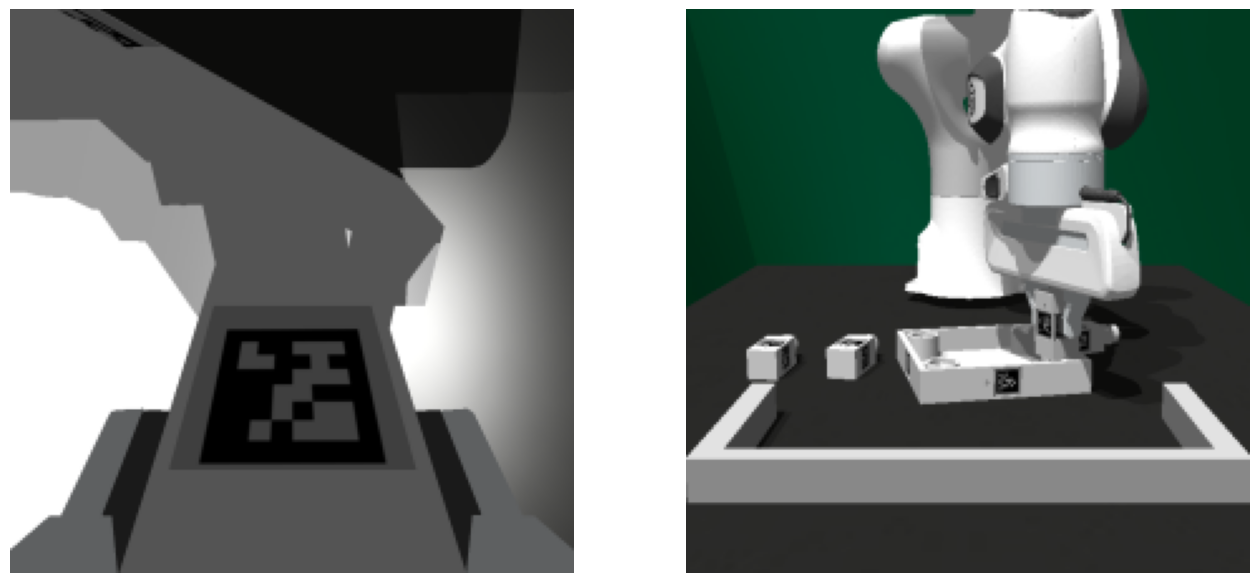

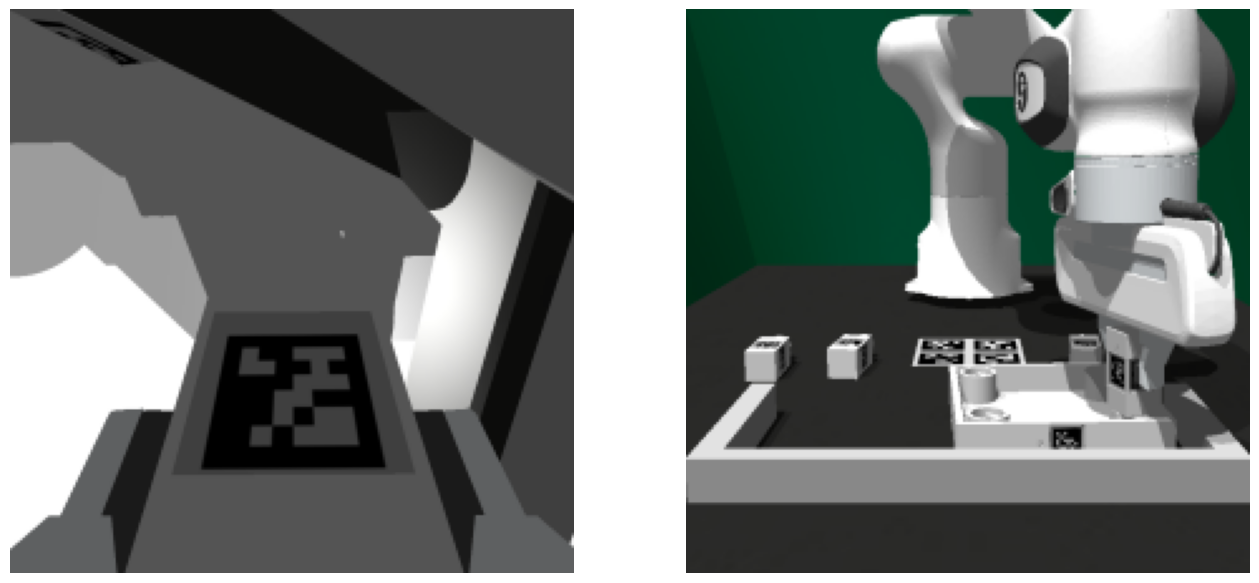

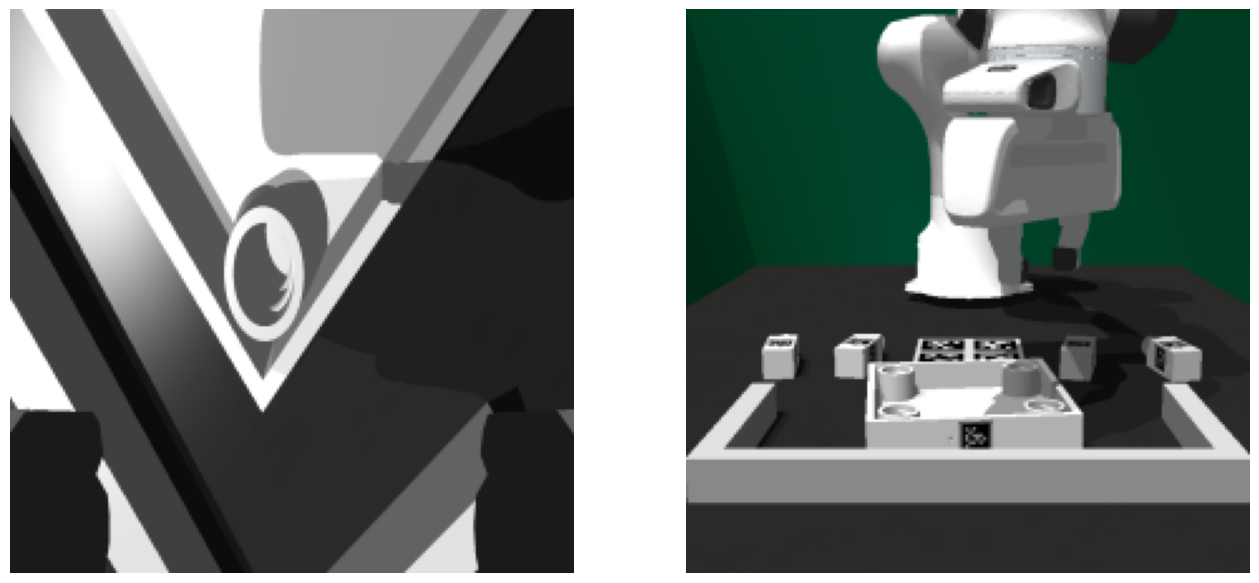

In [20]:
pbar = tqdm(glob("scripted_sim_demo/**/*.pkl", recursive=True), ncols=100)
for pkl_name in pbar:
    run_name = pkl_name.split('/')[-1].split('.')[0]
    pbar.set_description(run_name)
    filename = f"videos/{run_name}.mp4"

    if os.path.exists(filename):
        continue

    ims1, ims2 = get_ims(pkl_name)
    render_mp4(ims1, ims2, filename=filename)